In [1]:
print('ok')

ok


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## Data Preparation

In [3]:
df = pd.read_csv('course_lead_scoring.csv')

In [4]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
df.shape

(1462, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [9]:
df.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [10]:
df['employment_status'].value_counts()

employment_status
self_employed    352
student          348
unemployed       334
employed         328
Name: count, dtype: int64

In [11]:
df['location'].value_counts()

location
north_america    225
europe           216
middle_east      198
asia             195
south_america    192
africa           188
australia        185
Name: count, dtype: int64

In [12]:
df['industry'].value_counts()

industry
retail           203
finance          200
other            198
education        187
healthcare       187
technology       179
manufacturing    174
Name: count, dtype: int64

In [14]:
df['lead_source'].value_counts()

lead_source
organic_search    282
social_media      278
paid_ads          264
referral          260
events            250
Name: count, dtype: int64

In [16]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [17]:
#Identify Categorical Features and fill with 'NA'
categorical_features = ['lead_source', 'industry', 'employment_status', 'location']
df[categorical_features] = df[categorical_features].fillna('NA')

# Identify Numerical Features and fill with 0.0
numerical_features = ['annual_income']
df[numerical_features] = df[numerical_features].fillna(0.0)

#Verifying the changes (
print("Missing values after imputation:")
print(df.isna().sum())

Missing values after imputation:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution.
- Use train_test_split function for that with random_state=1

In [23]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [29]:
X = df.drop(columns=['converted']) 
y = df['converted']

non_missing_indices = y.dropna().index
X = X.loc[non_missing_indices]
y = y.loc[non_missing_indices]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"X_train size: {len(X_train)}")
print(f"X_val size: {len(X_val)}")
print(f"X_test size: {len(X_test)}")

X_train size: 877
X_val size: 292
X_test size: 293


### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [30]:
numeric = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_values = {}

for col in numeric:
    auc = roc_auc_score(y_train, X_train[col])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])

    auc_values[col] = auc

print("AUC values:")
for col, auc in auc_values.items():
    print(f"{col}: {auc:.3f}")

best_variable = max(auc_values, key=auc_values.get)

print(f"The numerical variable with the highest AUC is: {best_variable} with AUC = {auc_values[best_variable]:.3f}")

AUC values:
lead_score: 0.611
number_of_courses_viewed: 0.765
interaction_count: 0.727
annual_income: 0.545
The numerical variable with the highest AUC is: number_of_courses_viewed with AUC = 0.765


### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

````LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)````
- What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [31]:
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])

pipeline.fit(X_train_dict, y_train)

y_pred_proba = pipeline.predict_proba(X_val_dict)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)

print(f'AUC: {auc:.3f}')

AUC: 0.794


### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them
  
At which threshold precision and recall curves intersect?

- 0.145
- 0.345
- 0.545
- 0.745

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


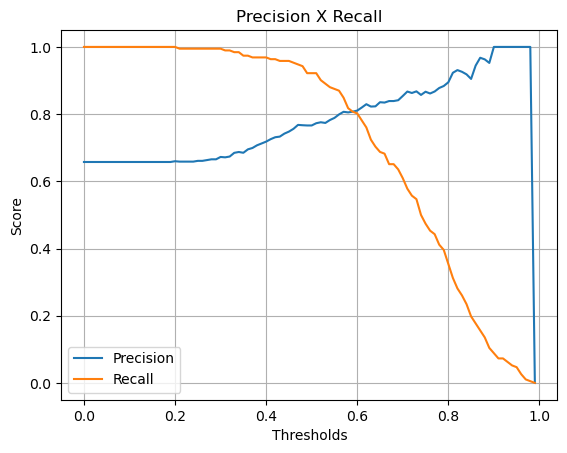

In [33]:
# Precison, Recall, and Thresholds
precisions = []
recalls = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterate over Thresholds
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)

    precision = precision_score(y_val, y_pred)
    recall =recall_score(y_val, y_pred)

    precisions.append(precision)
    recalls.append(recall)

#Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

plt.title('Precision X Recall')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \frac{P \cdot R}{P + R}$$

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Max F1 Score: 0.8485 at threshold: 0.470


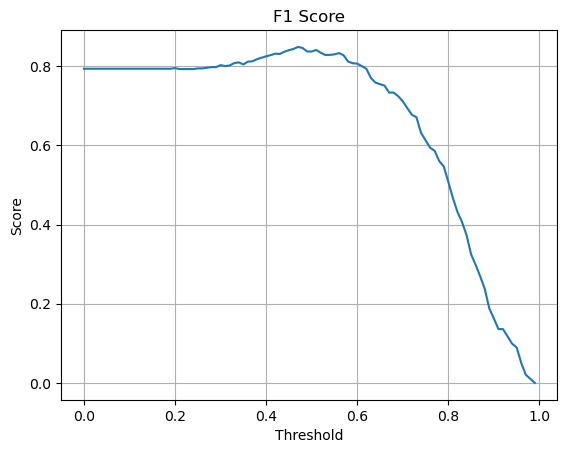

In [34]:
# F1 Score and thresholds
f1s = []
thresholds = np.arange(0.0, 1.0, 0.01)

# iterate over thresholds
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    f1s.append(f1)

max_f1 = np.argmax(f1s)
best_threshold = thresholds[max_f1]
best_f1_score = f1s[max_f1]
print(f'Max F1 Score: {best_f1_score:.4f} at threshold: {best_threshold:.3f}')

# plot precision and recall curves
plt.plot(thresholds, f1s, label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.show()

### Question 5: 5-Fold CV
Use the ```KFold``` class from Scikit-Learn to evaluate our model on 5 different folds:

````KFold(n_splits=5, shuffle=True, random_state=1)````

- Iterate over different folds of ``df_full_train``
- Split the data into train and validation
- Train the model on train with these parameters: ````LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)````
- Use AUC to evaluate the model on validation
  
How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline = Pipeline([
        ('vectorizer', DictVectorizer(sparse=False)),
        ('model', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
    ])
    
    pipeline.fit(X_train.to_dict(orient='records'), y_train)
    
    y_pred_proba = pipeline.predict_proba(X_val.to_dict(orient='records'))[:, 1]
    
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("AUC scores for each fold:", auc_scores)
print(f"Standard deviation of AUC scores across different folds: {std_auc:.3f}")

AUC scores for each fold: [np.float64(0.8172202350536536), np.float64(0.7792846497764531), np.float64(0.8309278350515464), np.float64(0.8675988428158148), np.float64(0.8093413173652695)]
Standard deviation of AUC scores across different folds: 0.029


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter ``C.``

- Iterate over the following ``C`` values: ``[0.000001, 0.001, 1]``
- Initialize ``KFold`` with the same parameters as previously
- Use these parameters for the model: ``LogisticRegression(solver='liblinear', C=C, max_iter=1000)``
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
  
Which ``C`` leads to the best mean score?

- 0.000001
- 0.001
- 1
  
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [37]:
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_results = {}

for C in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline = Pipeline([
            ('vectorizer', DictVectorizer(sparse=False)),
            ('model', LogisticRegression(solver='liblinear', C=C, max_iter=1000))
        ])
        
        pipeline.fit(X_train.to_dict(orient='records'), y_train)
        
        y_pred_proba = pipeline.predict_proba(X_val.to_dict(orient='records'))[:, 1]
        
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    auc_results[C] = {'mean_auc': round(mean_auc, 3), 'std_auc': round(std_auc, 3)}

for C, result in auc_results.items():
    print(f"C={C}: Mean AUC = {result['mean_auc']}, Std AUC = {result['std_auc']}")

best_C = min(auc_results.keys(), key=lambda C: (-auc_results[C]['mean_auc'], auc_results[C]['std_auc']))

print(f"Best C: {best_C}")

C=1e-06: Mean AUC = 0.549, Std AUC = 0.03
C=0.001: Mean AUC = 0.862, Std AUC = 0.024
C=1: Mean AUC = 0.821, Std AUC = 0.029
Best C: 0.001
